<a href="https://colab.research.google.com/github/Hatimkl/Bankist/blob/main/diffusers/deepfloyd_if_free_tier_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running IF with 🧨 diffusers on a Free Tier Google Colab

_**TL;DR**: We show how to run one of the most powerful open-source text to image models **IF** on a free-tier Google Colab with 🧨 diffusers._

*by DeepFloyd &* 🤗 *HuggingFace*




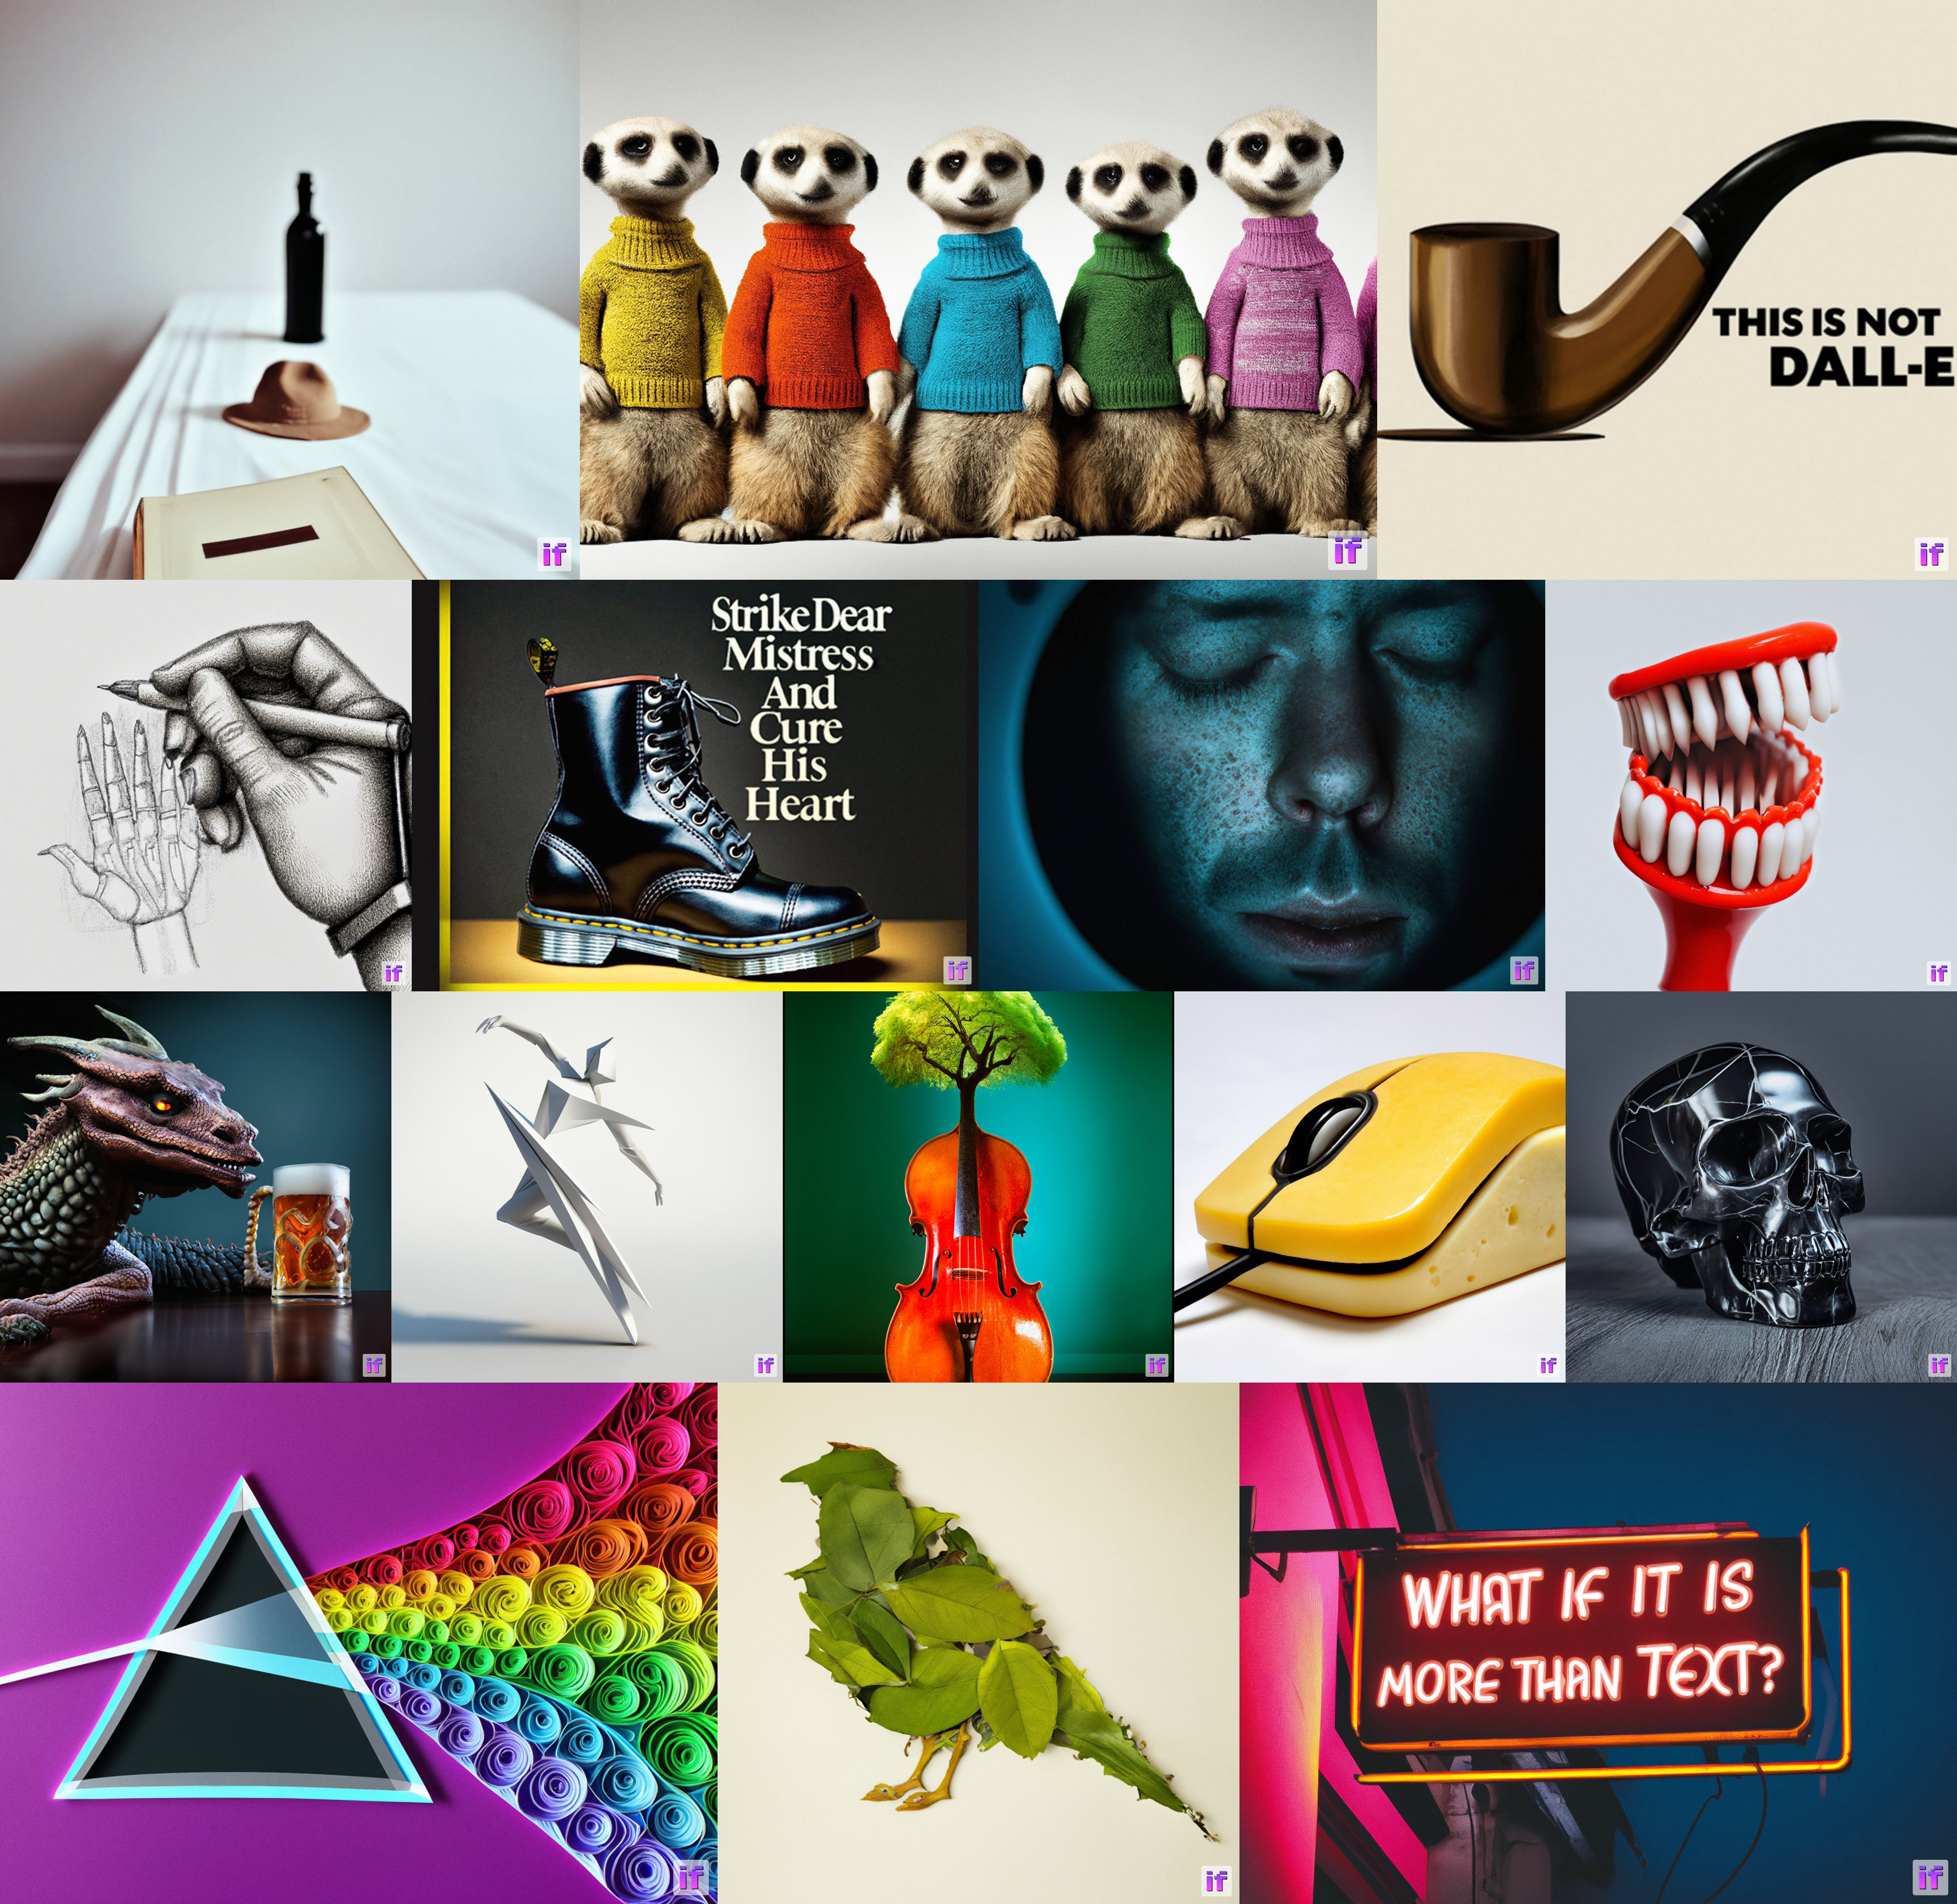

*Image taken from official IF GitHub repo [here](https://github.com/deep-floyd/IF/blob/release/pics/nabla.jpg)*

## Introduction

IF is a pixel-based text-to-image generation model and was [released in late April 2023 by DeepFloyd](https://github.com/deep-floyd/IF). The model architecture is strongly inspired by [Google's closed-sourced Imagen](https://imagen.research.google/).

IF has two distinct advantages compared to existing text-to-image models like Stable Diffusion:
- The model operates directly in "pixel space" (*i.e.,* on uncompressed images) instead of running the denoising process in the latent space such as [Stable Diffusion](http://hf.co/blog/stable_diffusion).
- The model is trained on outputs of [T5-XXL](https://huggingface.co/google/t5-v1_1-xxl), a more powerful text encoder than [CLIP](https://openai.com/research/clip), used by Stable Diffusion as the text encoder.

As a result, IF is better at generating images with high-frequency details (*e.g.,* human faces, and hands) and is the first open-source image generation model that can reliably generate images with text.

The downside of operating in pixel space and using a more powerful text encoder is that IF has a significantly higher amount of parameters. T5, IF's text-to-image UNet, and IF's upscaler UNet have 4.5B, 4.3B, and 1.2B parameters respectively. Compared this to [Stable Diffusion 2.1](https://huggingface.co/stabilityai/stable-diffusion-2-1)'s text encoder and UNet having just 400M and 900M parameters respectively.

Nevertheless, it is possible to run IF on consumer hardware if one optimizes the model for low-memory usage. We will show you can do this with 🧨 diffusers in this blog post.

In 1.), we explain how to use IF for text-to-image generation and in 2.) and 3.) we go over IF's image variation and image inpainting capabilities.

💡 **Note**: To a big part we are trading gains in memory by gains in speed here to make it possible to run IF in a free-tier Google Colab. If you have access to high-end GPUs such as a A100, we recommend to simply leave all model components on GPU for maximum speed as done in the [official IF demo](https://huggingface.co/spaces/DeepFloyd/IF).

Let's dive in 🚀!

## Optimizing IF to run on memory constrained hardware

State-of-the-art ML should not just be in the hands of an elite few. Democratizing ML means making models available to run on more than just the latest and greatest hardware.

The deep learning community has created world class tools to run resource intensive models on consumer hardware:
- [🤗 accelerate](https://github.com/huggingface/accelerate) provides utilities for working with [large models](https://huggingface.co/docs/accelerate/usage_guides/big_modeling).
- [bitsandbytes](https://github.com/TimDettmers/bitsandbytes) makes [8bit quantization](https://github.com/TimDettmers/bitsandbytes#features) available to all PyTorch models.
- [🤗 safetensors](https://github.com/huggingface/safetensors) not only ensures that save code is executed but also significantly speeds up the loading time of large models.

Diffusers seemlessly integrates the above libraries to allow for a simple API when optimizing large models.

The free-tier Google Colab is both CPU RAM constrained (13 GB RAM) as well as GPU VRAM constrained (15 GB RAM for T4) which makes running the whole >10B IF model challenging!

Let's map out the size of IF's model components in full float32 precision:
- [T5-XXL Text Encoder](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0/tree/main/text_encoder): 20GB
- [Stage 1 UNet](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0/tree/main/unet): 17.2 GB
- [Stage 2 Super Resolution UNet](https://huggingface.co/DeepFloyd/IF-II-L-v1.0/blob/main/pytorch_model.bin): 2.5 GB
- [Stage 3 Super Resolution Model](https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler): 3.4 GB

There is no way we can run the model in float32 as the T5 and Stage 1 UNet weights are each larger than the available CPU RAM.

In float16, the component sizes are 11GB, 8.6GB and 1.25GB for T5, Stage1 and Stage2 UNets respectively which is doable for the GPU, but we're still running into CPU memory overflow errors when loading the T5 (some CPU is occupied by other processes).

Therefore, we lower the precision of T5 even more by using `bitsandbytes` 8bit quantization which allows to save the T5 checkpoint with as little as [8 GB](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0/blob/main/text_encoder/model.8bit.safetensors).

Now that each components fits individually into both CPU and GPU memory, we need to make sure that components have all the CPU and GPU memory for themselves when needed.

Diffusers supports modularly loading individual components i.e. we can load the text encoder without loading the unet. This modular loading will ensure that we only load the component we need at a given step in the pipeline to avoid exhausting the available CPU RAM and GPU VRAM.

Let's give it a try 🚀

## Available resources

The free-tier Google Colab comes with around 13 GB CPU RAM:

In [31]:
!grep MemTotal /proc/meminfo

MemTotal:       13290460 kB


And an NVIDIA T4 with 15 GB VRAM:

In [32]:
!nvidia-smi

Wed Mar 26 14:49:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install dependencies

Some optimizations can require up-to-date versions of dependencies. If you are having issues, please double check and upgrade versions.

In [1]:
! pip install --upgrade \
  diffusers~=0.16 \
  transformers~=4.28 \
  safetensors~=0.3 \
  sentencepiece~=0.1 \
  accelerate~=0.18 \
  bitsandbytes~=0.38 \
  torch~=2.0 -q \
  -q bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

 ## Accepting the license

Before you can use IF, you need to accept its usage conditions. To do so:

- 1. Make sure to have a [Hugging Face account](https://huggingface.co/join) and be loggin in
- 2. Accept the license on the model card of [DeepFloyd/IF-I-XL-v1.0](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0). Accepting the license on the stage I model card will auto accept for the other IF models.
- 3. Make sure to login locally. Install `huggingface_hub`

In [ ]:
!pip install huggingface_hub --upgrade

and run the login function in a Python shell

In [35]:
from huggingface_hub import login

login()

## 1. Text-to-image generation

We will walk step by step through text-to-image generation with IF using Diffusers. We will explain briefly APIs and optimizations, but more in-depth explanations can be found in the official documentation for [Diffusers](https://huggingface.co/docs/diffusers/index), [Transformers](https://huggingface.co/docs/transformers/index), [Accelerate](https://huggingface.co/docs/accelerate/index), and [bitsandbytes](https://github.com/TimDettmers/bitsandbytes).

### 1.1 Load text encoder

We will load T5 using 8bit quantization. Transformers directly supports [bitsandbytes](https://huggingface.co/docs/transformers/main/en/main_classes/quantization#load-a-large-model-in-8bit) through the `load_in_8bit` flag.

The flag `variant="8bit"` will download pre-quantized weights.

We also use the `device_map` flag to allow `transformers` to offload model layers to the CPU or disk. Transformers big modeling supports arbitrary device maps which can be used to separately load model parameters directly to available devices. Passing `"auto"` will automatically create a device map. See the `transformers` [docs](https://huggingface.co/docs/accelerate/usage_guides/big_modeling#designing-a-device-map) for more information.

In [36]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder",
    device_map="auto",
    load_in_8bit=True,
    variant="8bit"
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

### 1.2 Create text embeddings

The Diffusers API for accessing diffusion models is the `DiffusionPipeline` class and its subclasses. Each instance of `DiffusionPipeline` is a fully self contained set of methods and models for running diffusion networks. We can override the models it uses by passing alternative instances as keyword arguments to `from_pretrained`.

In this case, we pass `None` for the `unet` argument so no UNet will be loaded. This allows us to run the text embedding portion of the diffusion process without loading the UNet into memory.

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=text_encoder, # pass the previously instantiated 8bit text encoder
    unet=None,
    device_map="auto"
)

IF also comes with a super resolution pipeline. We will save the prompt embeddings so that we can later directly pass them to the super resolution pipeline. This will allow the super resolution pipeline to be loaded **without** a text encoder.

Instead of [an astronaut just riding a horse](https://huggingface.co/blog/stable_diffusion), let's hand him a sign as well!

Let's define a fitting prompt:

In [ ]:
prompt = 'a photograph of an astronaut riding a horse holding a sign that says "Pixel\'s in space"'

and run it through the 8bit quantized T5 model:

In [ ]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

### 1.3 Free memory

Once the prompt embeddings have been created. We do not need the text encoder anymore. However, it is still in memory on the GPU. We need to remove it so that we can load the UNet.

It's non-trivial to free PyTorch memory. We must garbage collect the Python objects which point to the actual memory allocated on the GPU.

First, use the python keyword `del` to delete all python objects referencing allocated GPU memory



In [ ]:
del text_encoder
del pipe

The deletion of the python object is not enough to free the GPU memory. Garbage collection is when the actual GPU memory is freed.

Additionally, we will call `torch.cuda.empty_cache()`. This method isn't strictly necessary as the cached cuda memory will be immediately available for further allocations. Emptying the cache allows us to verify in the colab UI that the memory is available.

We'll use a helper function `flush()` to flush memory.

In [ ]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()

and run it

In [ ]:
flush()

### 1.4 Stage 1: The main diffusion process

With our now available GPU memory, we can re-load the `DiffusionPipeline` with only the UNet to run the main diffusion process.

The `variant` and `torch_dtype` flags are used by Diffusers to download and load the weights in 16 bit floating point format.

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="auto"
)

Often, we directly pass the text prompt to `DiffusionPipeline.__call__`. However, we previously computed our text embeddings which we can pass instead.

IF also comes with a super resolution diffusion process. Setting `output_type="pt"` will return raw PyTorch tensors instead of a PIL image. This way we can keep the Pytorch tensors on GPU and pass them directly to the stage 2 super resolution pipeline.

Let's define a random generator and run the stage 1 diffusion process.

In [ ]:
generator = torch.Generator().manual_seed(1)
image = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

Let's manually convert the raw tensors to PIL and have a sneak peak at the final result. The output of stage 1 is a 64x64 image.

In [ ]:
from diffusers.utils import pt_to_pil

pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

And again, we remove the Python pointer and free CPU and GPU memory:

In [ ]:
del pipe
flush()

### 1.5 Stage 2: Super Resolution 64x64 to 256x256

IF comes with a separate diffusion process for upscaling.

We run each diffusion process with a separate pipeline.

The super resolution pipeline can be loaded with a text encoder if needed. However, we will usually have pre-computed text embeddings from the first IF pipeline. If so, load the pipeline without the text encoder.

Create the pipeline

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0",
    text_encoder=None, # no use of text encoder => memory savings!
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="auto"
)

and run it, re-using the pre-computed text embeddings

In [ ]:
image = pipe(
    image=image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

Again we can inspect the intermediate results.

In [ ]:
pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

And again, we delete the Python pointer and free memory

In [ ]:
del pipe
flush()

### 1.6 Stage 3: Super Resolution 256x256 to 1024x1024

The second super resolution model for IF is the previously release [Stability AI's x4 Upscaler](https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler).

Let's create the pipeline and load it directly on GPU with `device_map="auto"`.

Note that `device_map="auto"` with certain pipelines will throw errors in diffusers versions from `v0.16-v0.17`. You will either have to upgrade to a later version
if one exists or install from main with `pip install git+https://github.com/huggingface/diffusers.git@main`

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler",
    torch_dtype=torch.float16,
    device_map="auto"
)

🧨 diffusers makes independently developed diffusion models easily composable as pipelines can be chained together. Here we can just take the previous PyTorch tensor output and pass it to the tage 3 pipeline as `image=image`.

💡 **Note**: The x4 Upscaler does not use T5 and has [its own text encoder](https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler/tree/main/text_encoder). Therefore, we cannot use the previously created prompt embeddings and instead must pass the original prompt.

In [ ]:
pil_image = pipe(prompt, generator=generator, image=image).images

Unlike the IF pipelines, the IF watermark will not be added by default to outputs from the Stable Diffusion x4 upscaler pipeline.

We can instead manually apply the watermark.

In [ ]:
from diffusers.pipelines.deepfloyd_if import IFWatermarker

watermarker = IFWatermarker.from_pretrained("DeepFloyd/IF-I-XL-v1.0", subfolder="watermarker")
watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

View output image

In [ ]:
pil_image[0]

Et voila! A beautiful 1024x1024 image in a free-tier Google Colab.

We have shown how 🧨 diffusers makes it easy to decompose and modularly load resource intensive diffusion models.

💡 **Note**: We don't recommend using the above setup in production. 8bit quantization, manual de-allocation of model weights, and disk offloading all trade off memory for time (i.e., inference speed). This can be especially noticable if the diffusion pipeline is re-used. In production, we recommend using a 40GB A100 with all model components left on the GPU. See [**the official IF demo**](https://huggingface.co/spaces/DeepFloyd/IF).

## 2. Image variation

The same IF checkpoints can also be used for text guided image variation and inpainting. The core diffusion process is the same as text to image generation except the initial noised image is created from the image to be varied or inpainted.

To run image variation, load the same checkpoints with [`IFImg2ImgPipeline.from_pretrained()`](https://huggingface.co/docs/diffusers/api/pipelines/if#diffusers.IFImg2ImgPipeline) and [`IFImg2ImgSuperResolution.from_pretrained()`](https://huggingface.co/docs/diffusers/api/pipelines/if#diffusers.IFImg2ImgSuperResolution).

The APIs for memory optimization are all the same!

Let's free the memory from the previous section.

In [ ]:
del pipe

In [ ]:
flush()

For image variation, we start with an initial image that we want to adapt.

For this section, we will adapt the famous "Slaps Roof of Car" meme. Let's download it from the internet.

In [ ]:
import requests

url = "https://i.kym-cdn.com/entries/icons/original/000/026/561/car.jpg"
response = requests.get(url)

and load it into a PIL Image

In [ ]:
from PIL import Image
from io import BytesIO

original_image = Image.open(BytesIO(response.content)).convert("RGB")
original_image = original_image.resize((768, 512))
original_image

The image variation pipeline take both PIL images and raw tensors. View the docstrings for more indepth documentation on expected inputs, [here](https://huggingface.co/docs/diffusers/v0.16.0/en/api/pipelines/if#diffusers.IFImg2ImgPipeline.__call__)

### 2.1 Text Encoder

Image variation is guided by text, so we can define a prompt and encode it with T5's Text Encoder.

Again we load the text encoder into 8bit precision.

In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder",
    device_map="auto",
    load_in_8bit=True,
    variant="8bit"
)

For image variation, we load the checkpoint with [`IFImg2ImgPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/if#diffusers.IFImg2ImgPipeline). When using `DiffusionPipeline.from_pretrained(...)`, checkpoints are loaded into their default pipeline. The default pipeline for the IF is the text-to-image [`IFPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/if#diffusers.IFPipeline). When loading checkpoints with a non-default pipeline, the pipeline must be explicitly specified.

In [ ]:
from diffusers import IFImg2ImgPipeline

pipe = IFImg2ImgPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=text_encoder,
    unet=None,
    device_map="auto"
)

Let's turn our salesman into an anime character.

In [ ]:
prompt = "anime style"

As before, we create the text embeddings with T5

In [ ]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

and free GPU and CPU memory.

First remove the Python pointers

In [ ]:
del text_encoder
del pipe

and then free the memory

In [ ]:
flush()

### 2.2 Stage 1: The main diffusion process

Next, we only load the stage 1 UNet weights into the pipeline object, just like we did in the previous section.

In [ ]:
pipe = IFImg2ImgPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="auto"
)

The image variation pipeline requires both the original image and the prompt embeddings.

We can optionally use the `strength` argument to configure the amount of variation. `strength` directly controls the amount of noise added. Higher strength means more noise which means more variation.

In [ ]:
generator = torch.Generator().manual_seed(0)
image = pipe(
    image=original_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

Let's check the intermediate 64x64 again.

In [ ]:
pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

Looks good, we can free the memory and upscale the image again.

In [ ]:
del pipe

In [ ]:
flush()

### 2.3 Stage 2: Super Resolution

For super resolution, load the checkpoint with `IFImg2ImgSuperResolutionPipeline` and the same checkpoint as before.

In [ ]:
from diffusers import IFImg2ImgSuperResolutionPipeline

pipe = IFImg2ImgSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="auto"
)

💡 **Note**: The image variation super resolution pipeline requires the generated image as well as the original image.

You can also use the Stable Diffusion x4 upscaler on this image. Feel free to try it out using the code snippets in section 1.6.

In [ ]:
image = pipe(
    image=image,
    original_image=original_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    generator=generator,
).images[0]
image

Nice! Let's free the memory and look at the final inpainting pipelines.

In [ ]:
del pipe

In [ ]:
flush()

## 3. Inpainting

The IF inpainting pipeline is the same as the image variation except only a select area of the image is denoised.

We specify the area to inpatint with an image mask.

Let's show off IF's amazing "letter generation" capabilities. We can replace this sign text with different slogan.



First let's download the image

In [ ]:
import requests

url = "https://i.imgflip.com/5j6x75.jpg"
response = requests.get(url)

and turn it into a PIL Image

In [ ]:
from PIL import Image
from io import BytesIO

original_image = Image.open(BytesIO(response.content)).convert("RGB")
original_image = original_image.resize((512, 768))
original_image

We will mask the sign so we can replace its text.

For convenience, we have pre-generated the mask and loaded it into a HF dataset.

Let's download it.

In [ ]:
from huggingface_hub import hf_hub_download

mask_image = hf_hub_download("diffusers/docs-images", repo_type="dataset", filename="if/sign_man_mask.png")
mask_image = Image.open(mask_image)

mask_image

💡 **Note**: You can create masks yourself by manually creating a greyscale image.

In [ ]:
from PIL import Image
import numpy as np

height = 64
width = 64

example_mask = np.zeros((height, width), dtype=np.int8)

# Set masked pixels to 255
example_mask[20:30, 30:40] = 255

# Make sure to create the image in mode 'L'
# meaning single channel grayscale
example_mask = Image.fromarray(example_mask, mode='L')

example_mask

Now we can start inpainting 🎨🖌

### 3.1. Text Encoder

Again, we load the text encoder first


In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder",
    device_map="auto",
    load_in_8bit=True,
    variant="8bit"
)

This time, we initialize the `IFInpaintingPipeline` in-painting pipeline with the text encoder weights.


In [ ]:
from diffusers import IFInpaintingPipeline

pipe = IFInpaintingPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=text_encoder,
    unet=None,
    device_map="auto"
)

Alright, let's have the man advertise for more layers instead.

In [ ]:
prompt = 'the text, "just stack more layers"'

Having defined the prompt, we can create the prompt embeddings

In [ ]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

Just like before we free the memory

In [ ]:
del text_encoder
del pipe

In [ ]:
flush()

### 3.2 Stage 1: The main diffusion process

Just like before we now load the stage 1 pipeline with only the UNet.

In [ ]:
pipe = IFInpaintingPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="auto"
)

Now, we need to pass the input image, the mask image, and the prompt embeddings.

In [ ]:
image = pipe(
    image=original_image,
    mask_image=mask_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    output_type="pt",
    generator=generator,
).images

Let's take a look at the intermediate output.

In [ ]:
pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

Looks good! The text is pretty consistent!

Let's free the memory so we can upscale the image

In [ ]:
del pipe

In [ ]:
flush()

### 3.3 Stage 2: Super Resolution

For super resolution, load the checkpoint with `IFInpaintingSuperResolutionPipeline`.

In [ ]:
from diffusers import IFInpaintingSuperResolutionPipeline

pipe = IFInpaintingSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="auto"
)

The inpainting super resolution pipeline requires the generated image, the original image, the mask image, and the prompt embeddings.

Let's do a final denoising run.

In [ ]:
image = pipe(
    image=image,
    original_image=original_image,
    mask_image=mask_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds,
    generator=generator,
).images[0]
image

Nice, the model managed to generate text without making a single spelling error!

## Conclusion

IF in 32 bit floating point precision uses 40 GB of weights in total. We showed how using only open source models and libraries, IF can be ran on a free-tier Google Colab instance.

The ML ecosystem benefits deeply from the sharing of open tools and open models. This notebook alone used models from DeepFloyd, StabilityAI, and LAION. The libraries used -- Diffusers, Transformers, Accelerate, and bitsandbytes -- all benefit from countless contributors from different organizations.

A massive thank you to the DeepFloyd team for the creation and open sourcing of IF, and for contributing to the democratization of good machine learning 🤗.